In [1]:
import pandas as pd
import os
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import numpy as np

from torchsummary import summary

os.environ['TORCH_HOME'] = '/itf-fi-ml/shared/users/gerald/cache'
print("finished")

finished


In [12]:
dag_data = "/itf-fi-ml/shared/users/gerald/radiographs/dag/clips"
deniz_data = "/itf-fi-ml/shared/users/gerald/radiographs/deniz/clips"
angel_data = "/itf-fi-ml/shared/users/gerald/radiographs/charlies/clips"
csv_file = 'codefile.csv'

data_dirs = [dag_data, deniz_data, angel_data]
#data_dirs = [deniz_data]
csv_files = [csv_file]*3

model_save_dir = "/itf-fi-ml/shared/users/gerald/Python/RootResolverAI/model"
model_save_name = "RootResVGG19"
print("finished")

finished


In [13]:
## Lets data from more than one locationg be loaded:
from typing import Union

class CustomDataset(Dataset):
    def __init__(self, data_dirs, csv_files, transform=None):
        self.data_info = pd.DataFrame()
        self.data_dirs = data_dirs
        for i, (data_dir, csv_file) in enumerate(zip(data_dirs, csv_files)):
            full_csv_path = os.path.join(data_dir, csv_file)
            temp_df = pd.read_csv(full_csv_path)
            temp_df['data_dir'] = data_dir  # Add a column to store the corresponding directory
            self.data_info = pd.concat([self.data_info, temp_df])
        self.transform = transform

    def __len__(self):
        return len(self.data_info)
    
    def __getitem__(self, idx: Union[int, slice]):
        if isinstance(idx, slice):
            return [self.get_single_item(i) for i in range(*idx.indices(len(self)))]
        else:
            return self.get_single_item(idx)

    def get_single_item(self, idx):
        data_dir = self.data_info.iloc[idx]['data_dir']
        img_name = os.path.join(data_dir, self.data_info.iloc[idx, 0])
        image = Image.open(img_name).convert('L')  # Load as grayscale

        # Convert to numpy array and stack to create a 3-channel image
        image_np = np.array(image)
        image_np = np.stack([image_np]*3, axis=2)
        
        # Convert back to PIL Image
        image = Image.fromarray(image_np, 'RGB')

        label = int(self.data_info.iloc[idx, 1])

        if self.transform:
            image = self.transform(image)

        return image, label
print("finished")

finished


In [14]:
# Assuming you have defined a CustomDataset class and the transform you want to apply on the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # VGG19 expects 224x224 images
    transforms.ToTensor(),
    # Normalize using the mean and std dev values that the VGG19 was originally trained with
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
# Create your custom dataset
custom_dataset = CustomDataset(data_dirs=data_dirs, csv_files=csv_files, transform=transform)
print(len(custom_dataset))


# Split the dataset
train_dataset, val_dataset = train_test_split(custom_dataset, test_size=0.2, random_state=42)

# Create data loaders
batch_size = 64
print("4")
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
print("5")
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
print("finished")

3694
4
5
finished


In [15]:
from collections import defaultdict

# Initialize a dictionary to store class counts
class_counts = defaultdict(int)

# Iterate through the custom dataset and count class occurrences
for _, label in custom_dataset:
    class_counts[label] += 1

# Calculate the total number of samples
total_samples = len(custom_dataset)

# Calculate the percentage of each class
class_percentages = {label: count / total_samples * 100 for label, count in class_counts.items()}

# Create a Pandas DataFrame to display the statistics
statistics_df = pd.DataFrame({'Class': class_counts.keys(), 'Count': class_counts.values(), 'Percentage (%)': class_percentages.values()})

# Display the table in Jupyter Notebook
statistics_df

,Class,Count,Percentage (%)
0,3,1172,31.727125
1,2,726,19.653492
2,4,285,7.715214
3,1,1443,39.063346
4,5,68,1.840823


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

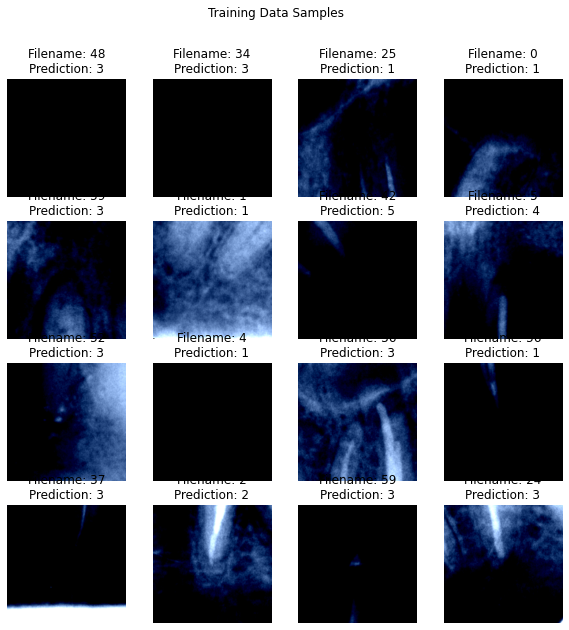

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

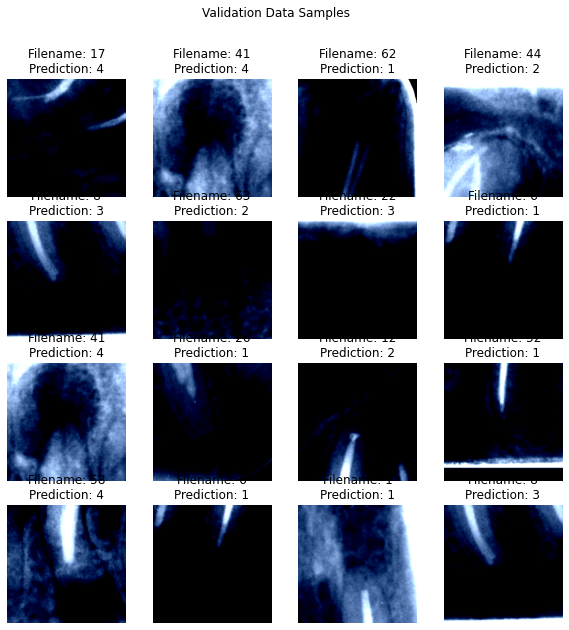

In [16]:
# Visualize some of the data
%matplotlib inline
import random

# Function to visualize 4x4 grid of images
def visualize_images(dataloader, title):
    plt.figure(figsize=(10, 10))
    plt.suptitle(title)
    for i in range(16):  # You can adjust this for a different grid size
        plt.subplot(4, 4, i+1)
        for images, labels in dataloader:
            img_idx = random.randint(0, images.shape[0] - 1)
            
            # Convert to numpy and transpose to fit matplotlib's channel order
            img = images[img_idx].numpy().transpose((1, 2, 0))
            
            # Inverse normalization (if you used normalization in transformations)
            img = img * np.array([1.0, 1.0, 1.0]) + np.array([0.0, 0.0, 0.0])
            
            plt.title(f"Filename: {img_idx}\nPrediction: {labels[img_idx]}")
            plt.imshow(img)
            plt.axis('off')
            
            break  # We break as we just need one batch of images
    plt.show()

# Visualize random images from train_loader and val_loader
visualize_images(train_loader, "Training Data Samples")
visualize_images(val_loader, "Validation Data Samples")


In [8]:
import torchvision.models as models
from torch.optim import Adam

# Load the pre-trained VGG19 model + higher-level layers using the 'weights' argument
model_filename = "vgg19_bn_model.pth"
# Full path to save the file
model_load_path = os.path.join(model_save_dir, model_filename)
model = models.vgg19_bn()
model.load_state_dict(torch.load(model_load_path))

# Freeze all layers in the model
for param in model.parameters():
    param.requires_grad = False

# Customize for the number of classes in your dataset
num_features = model.classifier[6].in_features
features = list(model.classifier.children())[:-1]  # Remove the last layer
features.extend([nn.Linear(num_features, 5)])  # Add the last layer with 5 classes
model.classifier = nn.Sequential(*features)  # Replace the model classifier

# Unfreeze training for the classifier layers
for param in model.classifier.parameters():
    param.requires_grad = True

# Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(str(device))

summary(model, (3, 224, 224))

cuda:0
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,928
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
         MaxPool2d-7         [-1, 64, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]          73,856
       BatchNorm2d-9        [-1, 128, 112, 112]             256
             ReLU-10        [-1, 128, 112, 112]               0
           Conv2d-11        [-1, 128, 112, 112]         147,584
      BatchNorm2d-12        [-1, 128, 112, 112]             256
             ReLU-13        [-1, 128, 112, 112]               0
        MaxPool2d-14          [-

Epoch 1/50 - Train Loss: 2.0549, Train Accuracy: 0.4321, Validation Loss: 1.1266, Validation Accuracy: 0.5399
Epoch 2/50 - Train Loss: 1.0492, Train Accuracy: 0.5607, Validation Loss: 1.1034, Validation Accuracy: 0.5332
Epoch 3/50 - Train Loss: 0.7578, Train Accuracy: 0.7066, Validation Loss: 1.1442, Validation Accuracy: 0.6184
Epoch 4/50 - Train Loss: 0.6273, Train Accuracy: 0.7743, Validation Loss: 1.0809, Validation Accuracy: 0.6387
Epoch 5/50 - Train Loss: 0.4340, Train Accuracy: 0.8504, Validation Loss: 1.2558, Validation Accuracy: 0.6617
Epoch 6/50 - Train Loss: 0.3209, Train Accuracy: 0.8849, Validation Loss: 1.2356, Validation Accuracy: 0.6563
Epoch 7/50 - Train Loss: 0.3181, Train Accuracy: 0.8941, Validation Loss: 1.3896, Validation Accuracy: 0.6373
Epoch 8/50 - Train Loss: 0.2863, Train Accuracy: 0.9073, Validation Loss: 1.4135, Validation Accuracy: 0.6360
Epoch 9/50 - Train Loss: 0.2373, Train Accuracy: 0.9320, Validation Loss: 1.3693, Validation Accuracy: 0.6712
Epoch 10/5

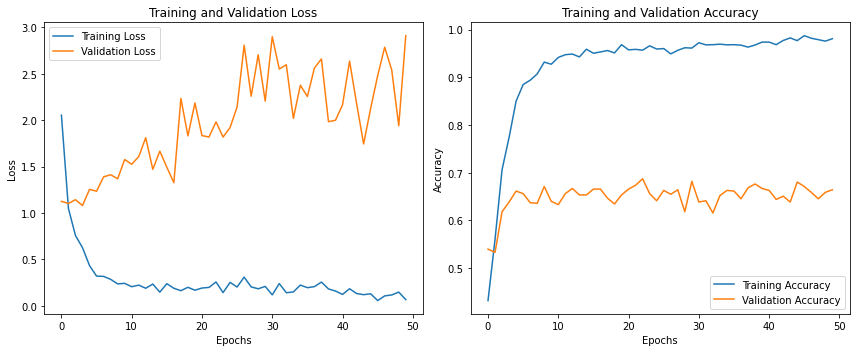

In [17]:
# Runs evaluation after each training epoch

import matplotlib.pyplot as plt

# Initialize lists to store loss and accuracy values for each epoch
train_loss_list = []
val_loss_list = []
train_accuracy_list = []
val_accuracy_list = []

# Number of training epochs
num_epochs = 50

for epoch in range(num_epochs):
    # Initialize metrics for each epoch
    train_loss = 0.0
    train_corrects = 0
    val_loss = 0.0
    val_corrects = 0
    
    # Training Loop
    model.train()
    for inputs, labels in train_loader:
        labels = labels - 1  # Decrement the labels by 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        train_corrects += torch.sum(preds == labels.data)
        
    # Validation Loop
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            labels = labels - 1
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels.data)
            
    # Calculate epoch loss and accuracy
    train_loss = train_loss / len(train_loader.dataset)
    train_accuracy = (train_corrects.double() / len(train_loader.dataset)).item()  # .item() converts it to a Python number
    val_loss = val_loss / len(val_loader.dataset)
    val_accuracy = (val_corrects.double() / len(val_loader.dataset)).item()  # .item() converts it to a Python number

    # Store metrics for plotting
    train_loss_list.append(train_loss)
    train_accuracy_list.append(train_accuracy)  # Appending Python numbers
    val_loss_list.append(val_loss)
    val_accuracy_list.append(val_accuracy)  # Appending Python numbers

    
    print(f'Epoch {epoch+1}/{num_epochs} - '
          f'Train Loss: {train_loss:.4f}, '
          f'Train Accuracy: {train_accuracy:.4f}, '
          f'Validation Loss: {val_loss:.4f}, '
          f'Validation Accuracy: {val_accuracy:.4f}')

# Plotting
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), train_loss_list, label='Training Loss')
plt.plot(range(num_epochs), val_loss_list, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(num_epochs), train_accuracy_list, label='Training Accuracy')
plt.plot(range(num_epochs), val_accuracy_list, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('training_validation_metrics.png')
plt.show()

In [ ]:
#Save model:
torch.save(model, os.path.join(model_save_dir, model_save_name))

In [8]:
# Initialize the pre-trained VGG19 model with batch normalization
model = models.vgg19_bn(pretrained=True)

# Define the directory and file name where you want to save the model
save_directory = model_save_dir
save_filename = "vgg19_bn_model.pth"

# Create the directory if it doesn't exist
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

# Full path to save the file
full_save_path = os.path.join(save_directory, save_filename)

# Save the model's state dictionary
torch.save(model.state_dict(), full_save_path)

print(f"Model has been saved to {full_save_path}")

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /itf-fi-ml/shared/users/gerald/cache/hub/checkpoints/vgg19_bn-c79401a0.pth
93.9%

Model has been saved to /itf-fi-ml/shared/users/gerald/Python/RootResolverAI/model/vgg19_bn_model.pth


In [ ]:
os._exit(0)